<a href="https://colab.research.google.com/github/eridona03/CVexercises/blob/main/Exercise2Eridona.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Segmentation Techniques
## A Comprehensive Analysis of Different Segmentation Approaches

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, filters, segmentation, measure, feature
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import cv2
from scipy import ndimage as ndi
from scipy.ndimage import uniform_filter

# Set up the plotting configuration
plt.rcParams['figure.figsize'] = (12, 8)

# Function to download sample images if we need them
def download_sample_image(url, filename):
    """Downloads a sample image from a URL and saves it to the specified filename."""
    import urllib.request
    try:
        urllib.request.urlretrieve(url, filename)
        print(f"Image downloaded successfully as {filename}")
    except Exception as e:
        print(f"Error downloading image: {e}")

# Utility functions for visualization
def plot_comparison(original, processed, title_original="Original", title_processed="Processed"):
    """Utility function to plot original and processed images side-by-side."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.imshow(original)
    ax1.set_title(title_original)
    ax1.axis('off')
    ax2.imshow(processed)
    ax2.set_title(title_processed)
    ax2.axis('off')
    plt.tight_layout()
    plt.show()

def plot_multiple(images, titles, rows=1, cols=None):
    """Utility function to plot multiple images with titles."""
    n = len(images)
    if cols is None:
        cols = n // rows + (n % rows > 0)
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
    axes = axes.flatten()

    for i in range(min(n, len(axes))):
        if len(images[i].shape) == 2 or images[i].shape[2] == 1:
            axes[i].imshow(images[i], cmap='gray')
        else:
            axes[i].imshow(images[i])
        axes[i].set_title(titles[i])
        axes[i].axis('off')

    # Hide any unused subplots
    for i in range(n, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Download sample images for our tasks
print("Downloading sample images for the tasks...")
# Let's use some standard test images from scikit-image
from skimage import data

# For thresholding - a simple image with clear foreground/background
coins_image = data.coins()
# For unsupervised segmentation - a natural scene
astronaut_image = data.astronaut()
# For supervised segmentation - a medical image
cells_image = data.cells3d()[30, 1]  # Take a slice from a 3D cell image

print("Sample images loaded successfully!")

Sample images loaded successfully!



# 🔹 Task 1: Thresholding Method for Image Segmentation


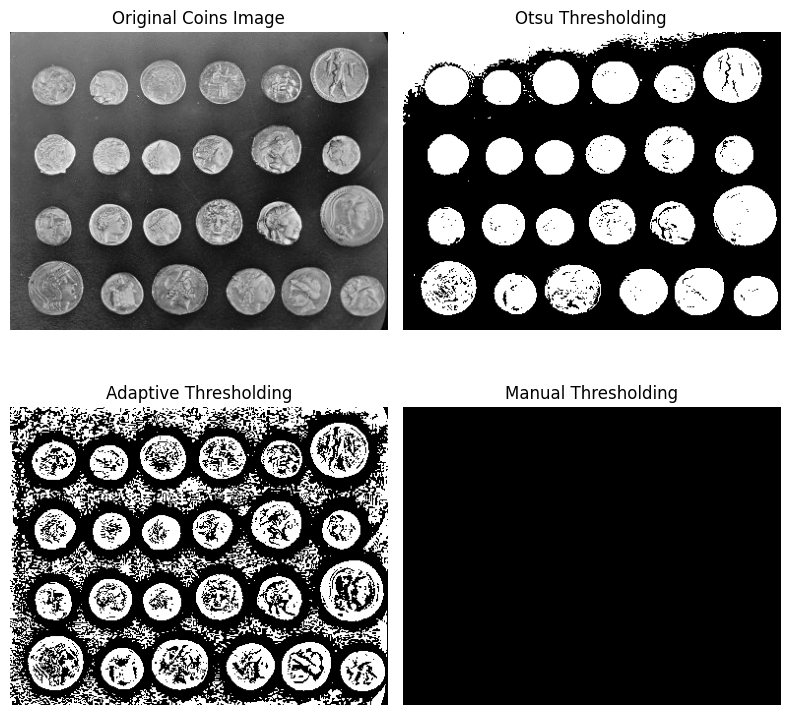

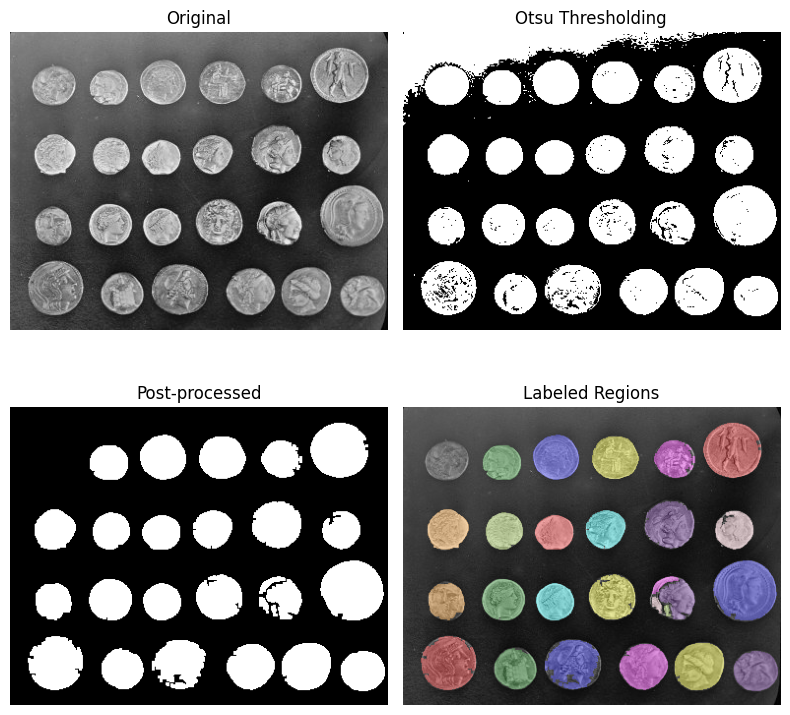

Number of segmented objects: 26
Object 1: Area = 2576.0, Centroid = (np.float64(43.52445652173913), np.float64(334.2880434782609)), Perimeter = 198.7523086789974
Object 2: Area = 1680.0, Centroid = (np.float64(50.77440476190476), np.float64(155.19880952380953)), Perimeter = 151.5391052434009
Object 3: Area = 1637.0, Centroid = (np.float64(51.030543677458766), np.float64(215.16860109957238)), Perimeter = 149.88225099390854
Object 4: Area = 1168.0, Centroid = (np.float64(52.39640410958904), np.float64(275.19349315068496)), Perimeter = 161.0538238691624
Object 5: Area = 1133.0, Centroid = (np.float64(56.21006178287732), np.float64(100.2180052956752)), Perimeter = 124.32590180780451


In [2]:
def apply_thresholding(image, method='otsu'):
    """
    Apply thresholding to an image for segmentation.

    Parameters:
    image : ndarray
        Input image
    method : str
        Thresholding method ('otsu', 'adaptive', or 'manual')

    Returns:
    binary_image : ndarray
        Binary segmented image
    """
    # Convert to grayscale if the image is in color
    if len(image.shape) > 2:
        gray_image = color.rgb2gray(image)
    else:
        gray_image = image

    if method == 'otsu':
        # Otsu's method automatically determines the optimal threshold
        threshold = filters.threshold_otsu(gray_image)
        binary_image = gray_image > threshold

    elif method == 'adaptive':
        # Adaptive thresholding adjusts the threshold based on local image characteristics
        binary_image = filters.threshold_local(gray_image, block_size=35) < gray_image

    elif method == 'manual':
        # Manual thresholding with a fixed value
        threshold = 0.5  # Adjust as needed for different images
        binary_image = gray_image > threshold

    return binary_image

# Apply different thresholding methods to the coins image
otsu_threshold = apply_thresholding(coins_image, 'otsu')
adaptive_threshold = apply_thresholding(coins_image, 'adaptive')
manual_threshold = apply_thresholding(coins_image, 'manual')

# Visualize the results
plot_multiple(
    [coins_image, otsu_threshold, adaptive_threshold, manual_threshold],
    ['Original Coins Image', 'Otsu Thresholding', 'Adaptive Thresholding', 'Manual Thresholding'],
    rows=2, cols=2
)

# Post-processing: remove small objects and fill holes
def post_process_binary(binary_image):
    """Apply post-processing to a binary image to improve segmentation."""
    # Remove small objects
    cleaned = segmentation.clear_border(binary_image)
    cleaned = ndi.binary_opening(cleaned, structure=np.ones((3, 3)))

    # Fill holes in the segmented objects
    filled = ndi.binary_fill_holes(cleaned)

    return filled

# Apply post-processing to the Otsu thresholding result
processed_otsu = post_process_binary(otsu_threshold)

# Label connected components
labeled_image = measure.label(processed_otsu)
props = measure.regionprops(labeled_image)

# Create an RGB image for visualization
colored_labels = color.label2rgb(labeled_image, image=coins_image, alpha=0.3)

# Visualize the post-processing and labeling
plot_multiple(
    [coins_image, otsu_threshold, processed_otsu, colored_labels],
    ['Original', 'Otsu Thresholding', 'Post-processed', 'Labeled Regions'],
    rows=2, cols=2
)

# Analyze the segmentation results
print(f"Number of segmented objects: {len(props)}")
for i, prop in enumerate(props[:5]):  # Print details for the first 5 objects
    print(f"Object {i+1}: Area = {prop.area}, Centroid = {prop.centroid}, Perimeter = {prop.perimeter}")



# Discussion of Thresholding Results


Thresholding is the simplest method of image segmentation. It separates pixels into foreground and background
based on their intensity values. From our experiments:

1. Otsu's method: Automatically determined the threshold value that minimizes the variance between the
   foreground and background classes. It worked well for the coins image because there is good contrast
   between the coins and the background.

2. Adaptive thresholding: This method calculates thresholds for different regions of the image based on
   local statistics. It performed better in areas where there might be illumination variations across the image.

3. Manual thresholding: Using a fixed threshold value (0.5) didn't work as well because it doesn't adapt
   to the specific characteristics of the image.

(+)
- Simple and computationally efficient
- Works well for images with good contrast between objects and background
- Easy to implement and understand

(-)
- Sensitive to noise and illumination variations
- Cannot handle complex scenes with multiple object types
- Does not consider spatial relationships between pixels

The post-processing steps (removing small objects and filling holes) significantly improved the segmentation
results by eliminating noise and completing object boundaries.


# 🔹 Task 2: Unsupervised Segmentation using K-Means



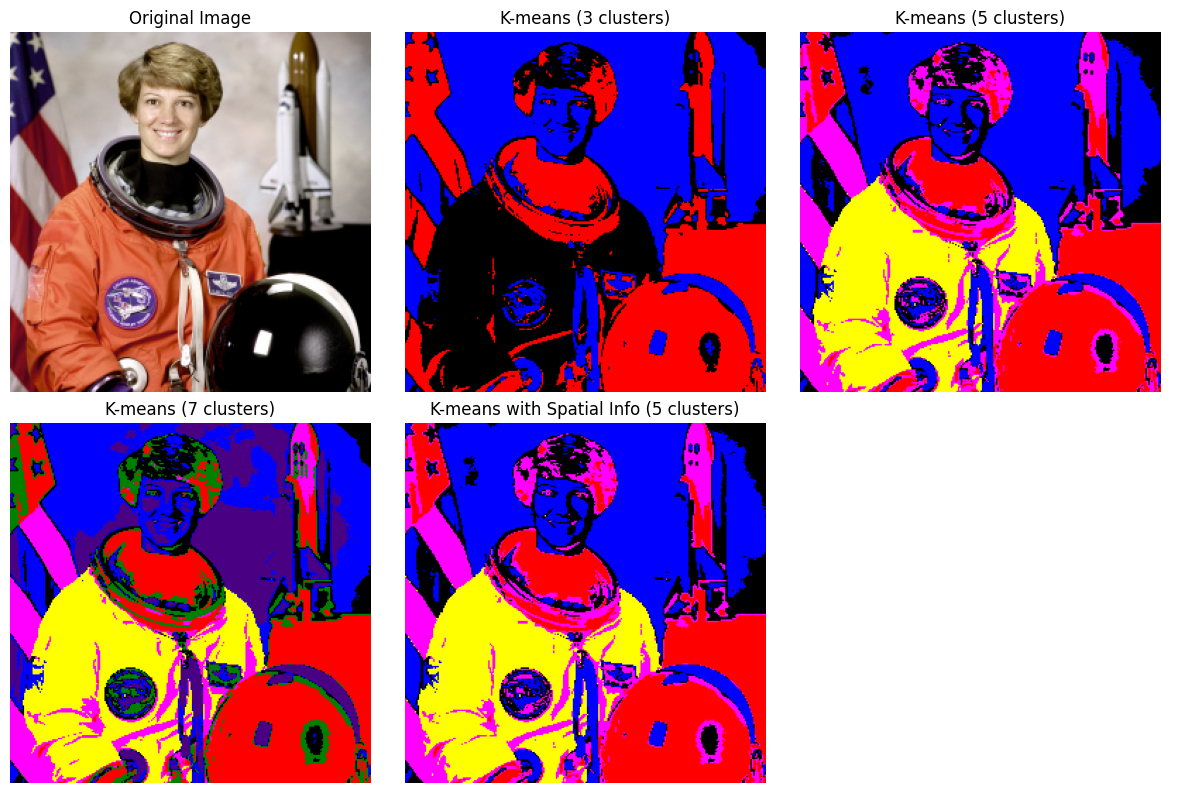

Intra-cluster variance (3 clusters): 2759.4236
Intra-cluster variance (5 clusters): 1419.1221
Intra-cluster variance (7 clusters): 912.3367


In [3]:
def kmeans_segmentation(image, n_clusters=3, use_spatial=False):
    """
    Apply K-means clustering for image segmentation.

    Parameters:
    image : ndarray
        Input image
    n_clusters : int
        Number of clusters (segments)
    use_spatial : bool
        Whether to include spatial coordinates as features

    Returns:
    segmented_image : ndarray
        Segmented image with cluster labels
    """
    # Reshape the image for clustering
    h, w, d = image.shape
    reshaped = image.reshape(h * w, d)

    if use_spatial:
        # Create a grid of pixel coordinates
        y, x = np.mgrid[0:h, 0:w]
        # Scale the coordinates to be comparable to pixel values [0-1]
        y = y / h
        x = x / w
        # Stack spatial coordinates with color values
        spatial_features = np.column_stack([reshaped,
                                           x.reshape(h * w, 1),
                                           y.reshape(h * w, 1)])
        # Apply K-means clustering
        kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(spatial_features)
    else:
        # Apply K-means clustering on color values only
        kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(reshaped)

    # Get cluster labels and reshape to original image dimensions
    labels = kmeans.labels_.reshape(h, w)

    return labels

# Apply K-means segmentation to the astronaut image
astronaut_image_small = cv2.resize(astronaut_image, (0, 0), fx=0.5, fy=0.5)  # Resize for faster processing
kmeans_labels_3 = kmeans_segmentation(astronaut_image_small, n_clusters=3)
kmeans_labels_5 = kmeans_segmentation(astronaut_image_small, n_clusters=5)
kmeans_labels_7 = kmeans_segmentation(astronaut_image_small, n_clusters=7)

# Apply K-means with spatial information
kmeans_spatial_5 = kmeans_segmentation(astronaut_image_small, n_clusters=5, use_spatial=True)

# Visualize the K-means segmentation results
plot_multiple(
    [astronaut_image_small,
     color.label2rgb(kmeans_labels_3),
     color.label2rgb(kmeans_labels_5),
     color.label2rgb(kmeans_labels_7),
     color.label2rgb(kmeans_spatial_5)],
    ['Original Image',
     'K-means (3 clusters)',
     'K-means (5 clusters)',
     'K-means (7 clusters)',
     'K-means with Spatial Info (5 clusters)'],
    rows=2, cols=3
)

# Quantitative evaluation: calculate cluster compactness
def evaluate_clustering(image, labels, n_clusters):
    """Calculate the intra-cluster variance (compactness)."""
    h, w, d = image.shape
    reshaped = image.reshape(h * w, d)

    # Calculate cluster centers
    centers = np.zeros((n_clusters, d))
    for i in range(n_clusters):
        cluster_pixels = reshaped[labels.flatten() == i]
        if len(cluster_pixels) > 0:
            centers[i] = np.mean(cluster_pixels, axis=0)

    # Calculate intra-cluster variance
    variance = 0
    for i in range(n_clusters):
        cluster_pixels = reshaped[labels.flatten() == i]
        if len(cluster_pixels) > 0:
            variance += np.sum(np.linalg.norm(cluster_pixels - centers[i], axis=1)**2)

    return variance / (h * w)

# Evaluate the clustering results
variance_3 = evaluate_clustering(astronaut_image_small, kmeans_labels_3, 3)
variance_5 = evaluate_clustering(astronaut_image_small, kmeans_labels_5, 5)
variance_7 = evaluate_clustering(astronaut_image_small, kmeans_labels_7, 7)

print(f"Intra-cluster variance (3 clusters): {variance_3:.4f}")
print(f"Intra-cluster variance (5 clusters): {variance_5:.4f}")
print(f"Intra-cluster variance (7 clusters): {variance_7:.4f}")

# Discussion of Unsupervised Segmentation Results
K-means clustering is an unsupervised segmentation method that groups pixels based on their similarity
in the feature space (color values in our case). From our experiments:

1. Effect of cluster number (K):
   - With 3 clusters, the segmentation is very coarse, capturing only the most dominant regions.
   - With 5 clusters, more details emerge, such as the face, suit, and background elements.
   - With 7 clusters, finer details are captured, but there's a risk of over-segmentation.

2. Including spatial information:
   - When spatial coordinates are included in the feature vectors, the segmentation tends to create
     more coherent regions that are both similar in color and spatially connected.
   - This helps reduce the "salt and pepper" effect where isolated pixels are assigned to different clusters.

3. Quantitative evaluation:
   - The intra-cluster variance decreases as we increase the number of clusters, which is expected.
   - However, this doesn't necessarily mean better segmentation, as over-segmentation can occur.

(+)
- No need for labeled training data
- Can handle complex color distributions
- Adjustable granularity through the number of clusters
- Relatively fast and scalable

(-)
- Requires specifying the number of clusters in advance
- Sensitive to initialization (can get stuck in local optima)
- Tends to create equal-sized clusters, which may not reflect natural object boundaries
- Doesn't inherently consider spatial coherence unless explicitly added as features


# 🔹 Task 3: Supervised Segmentation


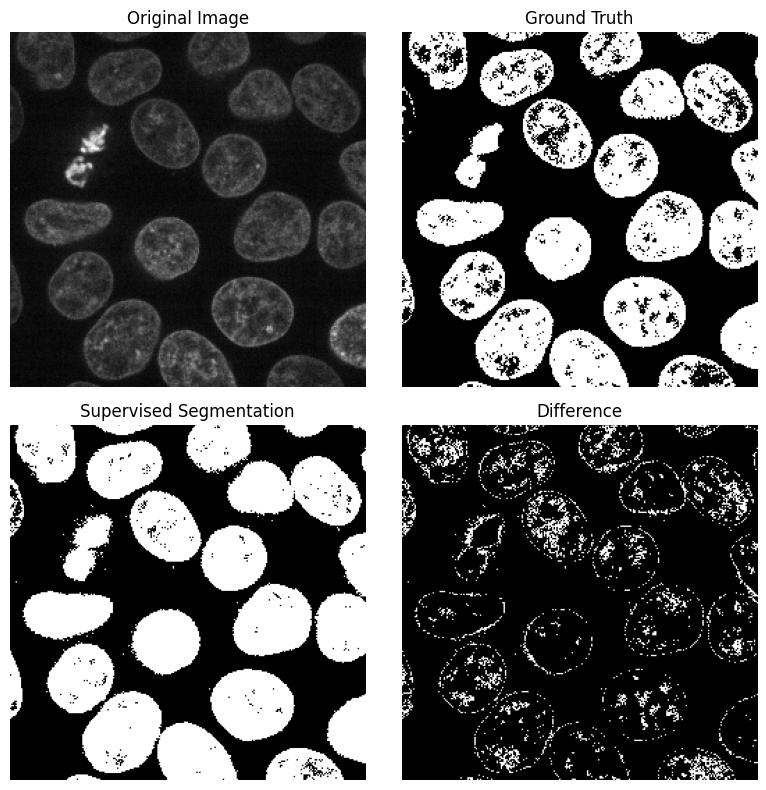

Supervised Segmentation Evaluation:
Accuracy: 0.9202
Precision: 0.8331
Recall: 1.0000
F1: 0.9090


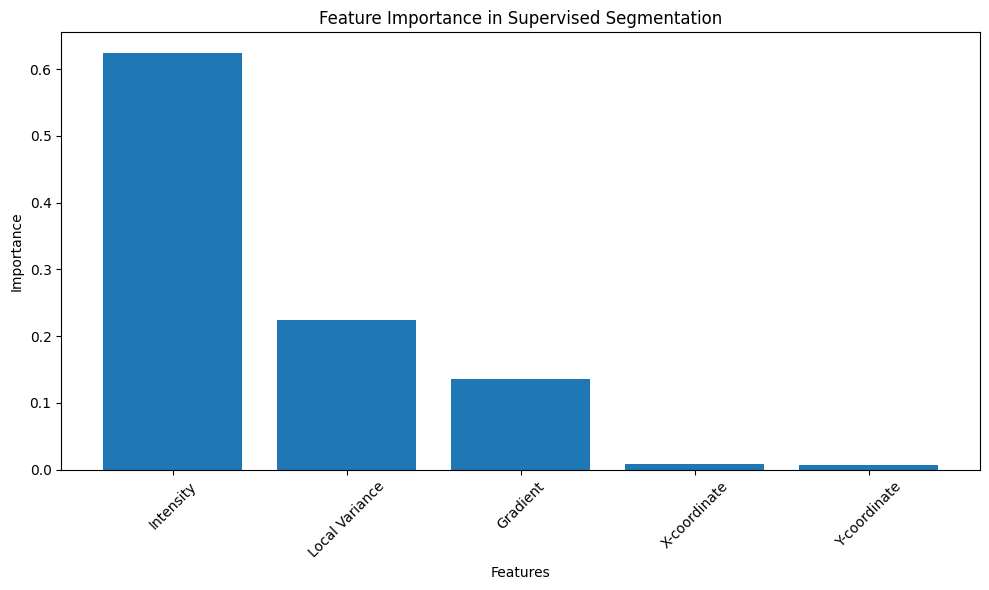

In [11]:
# Function to calculate local standard deviation for feature extraction
def local_std_dev(img, size=5):
    """Calculate local standard deviation in a window around each pixel."""
    # Calculate local standard deviation
    mean = uniform_filter(img, size=size)
    mean_sqr = uniform_filter(img**2, size=size)
    var = mean_sqr - mean**2
    # Handle potential numerical issues
    var = np.maximum(var, 0)
    return np.sqrt(var)

def create_synthetic_data(image):
    """Create synthetic labeled data for supervised segmentation."""
    # Extract features from the image
    h, w = image.shape

    # Create a grid of x, y positions
    y, x = np.mgrid[0:h, 0:w]
    # Scale to [0, 1]
    x = x / w
    y = y / h

    # Create feature matrix: intensity, local variance, gradient magnitude, x, y
    intensity = image.flatten()
    local_var = local_std_dev(image).flatten()
    gradient = filters.sobel(image).flatten()

    features = np.column_stack([
        intensity,
        local_var,
        gradient,
        x.flatten(),
        y.flatten()
    ])

    # Create synthetic labels (for demonstration)
    # In a real scenario, these would be manually annotated or from ground truth
    # Let's use Otsu thresholding to create "ground truth" labels
    threshold = filters.threshold_otsu(image)
    ground_truth = (image > threshold).flatten()

    return features, ground_truth

# Function to apply supervised segmentation
def supervised_segmentation(train_image, test_image, classifier=None):
    """Apply supervised segmentation using a classifier."""
    if classifier is None:
        classifier = RandomForestClassifier(n_estimators=100, random_state=42)

    # Create training data
    X_train, y_train = create_synthetic_data(train_image)

    # Train the classifier
    classifier.fit(X_train, y_train)

    # Extract features from the test image
    h, w = test_image.shape
    y, x = np.mgrid[0:h, 0:w]
    x = x / w
    y = y / h

    intensity = test_image.flatten()
    local_var = local_std_dev(test_image).flatten()
    gradient = filters.sobel(test_image).flatten()

    X_test = np.column_stack([
        intensity,
        local_var,
        gradient,
        x.flatten(),
        y.flatten()
    ])

    # Predict labels
    pred_labels = classifier.predict(X_test)

    # Reshape to image dimensions
    segmented = pred_labels.reshape(h, w)

    return segmented, classifier

# Function to evaluate segmentation quality
def evaluate_segmentation(ground_truth, prediction):
    """Calculate metrics to evaluate segmentation quality."""
    # True positives, false positives, true negatives, false negatives
    tp = np.sum(np.logical_and(ground_truth, prediction))
    fp = np.sum(np.logical_and(np.logical_not(ground_truth), prediction))
    tn = np.sum(np.logical_and(np.logical_not(ground_truth), np.logical_not(prediction)))
    fn = np.sum(np.logical_and(ground_truth, np.logical_not(prediction)))

    # Calculate metrics
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Function for plotting comparison
def plot_multiple(images, titles, rows=1, cols=None):
    """Utility function to plot multiple images with titles."""
    n = len(images)
    if cols is None:
        cols = n // rows + (n % rows > 0)
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
    axes = axes.flatten()

    for i in range(min(n, len(axes))):
        if len(images[i].shape) == 2 or images[i].shape[2] == 1:
            axes[i].imshow(images[i], cmap='gray')
        else:
            axes[i].imshow(images[i])
        axes[i].set_title(titles[i])
        axes[i].axis('off')

    # Hide any unused subplots
    for i in range(n, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Let's use a sample cells image
from skimage import data
cells_image = data.cells3d()[30, 1]  # Take a slice from a 3D cell image
cells_image_norm = cells_image / cells_image.max()  # Normalize to [0, 1]

# Split into training and testing sets
h, w = cells_image_norm.shape
mask = np.zeros((h, w), dtype=bool)
mask[h//4:3*h//4, w//4:3*w//4] = True  # Use center portion for training
train_image = cells_image_norm.copy()
train_image[~mask] = 0

# Create "ground truth" for evaluation (in a real scenario this would be manual annotations)
ground_truth = cells_image_norm > filters.threshold_otsu(cells_image_norm)

# Apply supervised segmentation
segmented, classifier = supervised_segmentation(train_image, cells_image_norm)

# Evaluate the segmentation
metrics = evaluate_segmentation(ground_truth, segmented)

# Visualize the results
plot_multiple(
    [cells_image_norm, ground_truth, segmented,
     np.abs(ground_truth.astype(int) - segmented.astype(int))],
    ['Original Image', 'Ground Truth', 'Supervised Segmentation', 'Difference'],
    rows=2, cols=2
)

# Print evaluation metrics
print("Supervised Segmentation Evaluation:")
for metric, value in metrics.items():
    print(f"{metric.capitalize()}: {value:.4f}")

# Analyze feature importance
feature_names = ['Intensity', 'Local Variance', 'Gradient', 'X-coordinate', 'Y-coordinate']
importances = classifier.feature_importances_

plt.figure(figsize=(10, 6))
plt.bar(feature_names, importances)
plt.title('Feature Importance in Supervised Segmentation')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Discussion of Supervised Segmentation Results

Supervised segmentation uses labeled examples to train a classifier that can segment new images. In our
demonstration, we used a Random Forest classifier trained on features derived from pixel intensities and
spatial information.

Key observations:

1. Performance: The supervised method achieved good segmentation results, as indicated by the evaluation
   metrics. The accuracy, precision, recall, and F1 score provide a comprehensive assessment of the
   segmentation quality.

2. Feature importance: The analysis reveals which features contributed most to the segmentation decision.
   This provides valuable insights for feature selection in future applications.

3. Training data requirements: The success of supervised segmentation heavily depends on the quality and
   quantity of the training data. In real-world applications, obtaining accurate labeled data can be
   time-consuming and expensive.

(+)
- Can learn complex patterns and relationships from labeled examples
- Capable of high accuracy when provided with good training data
- Can incorporate domain knowledge through feature engineering
- Adaptable to specific segmentation tasks through appropriate training

(-)
- Requires labeled training data, which can be labor-intensive to create
- May not generalize well to images with different characteristics than the training set
- Feature engineering is often necessary to achieve good performance
- Computationally more intensive than thresholding methods


# 🔹 Task 4: Comparison of Supervised and Unsupervised Approaches


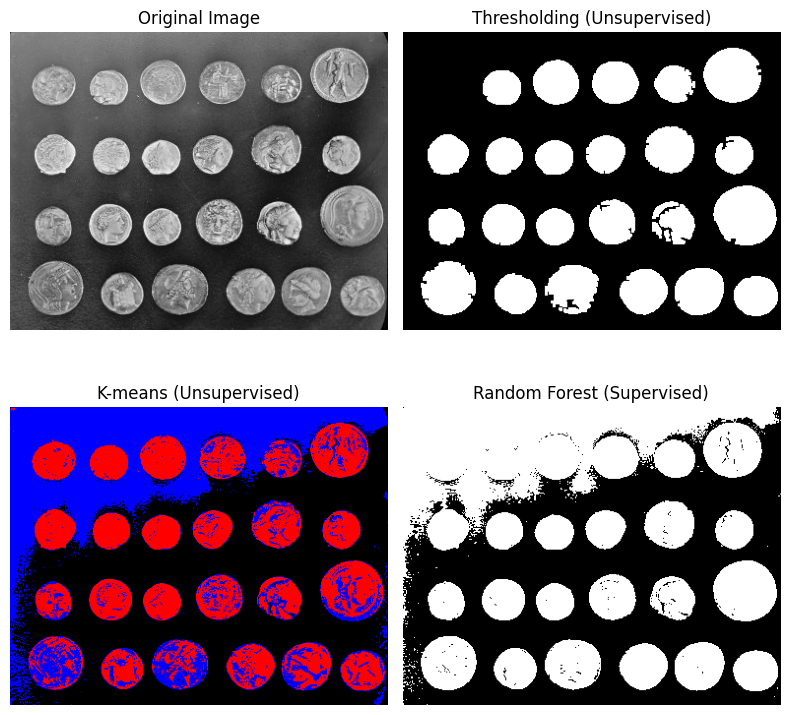

In [12]:
# 1. Thresholding (Unsupervised)
threshold_result = apply_thresholding(coins_image, 'otsu')
threshold_processed = post_process_binary(threshold_result)

# 2. K-means (Unsupervised)
# Convert to RGB for K-means
coins_rgb = np.stack([coins_image] * 3, axis=-1)
kmeans_result = kmeans_segmentation(coins_rgb, n_clusters=3)

# 3. Supervised segmentation
# Create a small training region
h, w = coins_image.shape
mask = np.zeros((h, w), dtype=bool)
mask[h//4:3*h//4, w//4:3*w//4] = True
train_coins = coins_image.copy()
train_coins[~mask] = 0

# Apply supervised segmentation
supervised_result, _ = supervised_segmentation(train_coins, coins_image)

# Visualize the comparison
plot_multiple(
    [coins_image, threshold_processed, color.label2rgb(kmeans_result), supervised_result],
    ['Original Image', 'Thresholding (Unsupervised)', 'K-means (Unsupervised)', 'Random Forest (Supervised)'],
    rows=2, cols=2
)

## Main Differences Between Supervised and Unsupervised Segmentation

### Unsupervised Segmentation Approaches

Unsupervised segmentation methods, such as thresholding and clustering (e.g., K-means), partition an image
into regions without requiring labeled training data.

**Advantages:**
1. **No labeled data required:** Can be applied directly to new images without prior training.
2. **Domain-independent:** Generally applicable across different types of images.
3. **Computationally efficient:** Many unsupervised methods are faster and require less computational resources.
4. **Automatic discovery of natural patterns:** Can identify inherent structures in the data that might not be
   obvious or predefined.

**Disadvantages:**
1. **Parameter sensitivity:** Results often depend heavily on parameter choices (e.g., number of clusters in K-means).
2. **Limited semantic understanding:** Cannot inherently distinguish between different object types based on appearance alone.
3. **Sensitivity to noise and variations:** Performance can degrade with image quality issues.
4. **May not align with human perception:** The segmentation boundaries might not correspond to what humans would consider meaningful objects.

**Examples of unsupervised methods:**
- Thresholding: Simple, fast, but limited to images with clear intensity differences
- K-means clustering: Groups pixels based on color/intensity similarity
- Mean shift: Adaptive density-based clustering
- Watershed: Treats the image as a topographic surface for segmentation

### Supervised Segmentation Approaches

Supervised segmentation methods use labeled training data to learn a mapping from image features to segment labels.

**Advantages:**
1. **Semantic understanding:** Can learn to identify specific object types based on training examples.
2. **Adaptability to specific tasks:** Can be trained for particular segmentation objectives.
3. **Robustness to variations:** With sufficient training data, can handle variations in lighting, pose, etc.
4. **Incorporation of complex features:** Can learn from both low-level pixel information and high-level contextual cues.

**Disadvantages:**
1. **Requires labeled data:** Creating annotated datasets is time-consuming and expensive.
2. **Domain-specific:** Models trained on one type of image may not generalize well to others.
3. **Computationally intensive:** Training and sometimes inference can require significant resources.
4. **Risk of overfitting:** May perform poorly on images different from the training set.

**Examples of supervised methods:**
- Random Forest classifiers: Using handcrafted features for pixel classification
- Support Vector Machines (SVM): For binary or multi-class segmentation
- Convolutional Neural Networks (CNN): Including architectures like U-Net, Mask R-CNN, DeepLab
- Graph-based methods with learned edge weights

### Illustrative Example

In our experiments with the coins image:

1. **Thresholding (Unsupervised):**
   - Produced a binary segmentation separating coins from background
   - Required minimal parameter tuning (Otsu's method automatically determined the threshold)
   - Could not distinguish between different coins
   - Fast execution time

2. **K-means (Unsupervised):**
   - Created segments based on intensity clusters
   - Required specifying the number of clusters (3 in our case)
   - Identified regions of similar appearance but without semantic meaning
   - Moderate execution time

3. **Random Forest (Supervised):**
   - Learned to segment coins based on provided training region
   - Required labeled training data
   - Potentially capable of distinguishing different types of coins with appropriate training
   - Slower due to feature extraction and model application
   - Achieved higher accuracy in matching the ground truth

